In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats
from scipy.stats import spearmanr,pearsonr,mannwhitneyu
from statsmodels.stats.multitest import multipletests

#from selenobot.reporter import Reporter

# Some specs to make sure everything is in line with Nature Micro requirements.
DPI = 500
TITLE_FONT_SIZE = 10
LABEL_FONT_SIZE = 10
FIGSIZE = (4, 3)
FONT = 'Arial'
PALETTE = 'Set1'

plt.rcParams['font.family'] = FONT


In [150]:
# load data
results_df = pd.read_pickle("../results/results_df.fullLength.13Nov2023.pkl")

In [154]:
results_df.total_hits.sum()

1689764

In [159]:
results_df.sort_values("total_hits")

,total_hits,hits_with_kegg_annotation,total_genes,total_genes_with_kegg_annotation,kegg_anotation_counts,selD_copy_num,selA_copy_num,total_genes_with_pfam_annotation,pfam_annotation_counts,ambiguous_bases,...,SelD_pos,SelA_pos,trna_sec_pos,UGA_Selenoproteins,UAA_Selenoproteins,UAG_Selenoproteins,UAA_FullLength,UAG_FullLength,UGA_FullLength,hit_fraction
GCA_902538565.1,0,0,981,575,{},0,0,0,{},0,...,False,False,False,0.0,0.0,0.0,649,149,183.0,0.000000
GCF_000019345.1,0,0,606,294,{},0,0,0,{},0,...,False,False,True,0.0,0.0,0.0,521,85,0.0,0.000000
GCA_902518505.1,0,0,1263,678,{},1,0,0,{},0,...,True,False,False,0.0,0.0,0.0,865,187,211.0,0.000000
GCA_900767715.1,0,0,939,419,{},0,0,0,{},0,...,False,False,False,0.0,0.0,0.0,638,213,88.0,0.000000
GCA_018061145.1,0,0,736,339,{},0,0,0,{},0,...,False,False,False,0.0,0.0,0.0,575,131,30.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCF_001499735.1,1172,8,7747,2357,"{'K00179': 1, 'K05588': 1, 'K07013': 1, 'K0775...",1,1,26,"{'PF00037': 2, 'PF00346': 1, 'PF00374': 5, 'PF...",1,...,True,True,True,679.0,227.0,266.0,1112,1293,4170.0,0.151284
GCA_000715825.1,1253,0,10635,2392,{},0,0,24,"{'PF00106': 1, 'PF00107': 1, 'PF00109': 1, 'PF...",40,...,False,False,False,295.0,56.0,902.0,305,2753,6324.0,0.117819
GCA_007858575.1,1464,16,11087,1517,"{'K00299': 1, 'K01297': 2, 'K01719': 1, 'K0195...",0,0,150,"{'PF00070': 1, 'PF00082': 1, 'PF00106': 5, 'PF...",0,...,False,False,False,764.0,45.0,655.0,353,1793,7477.0,0.132047
GCA_000715855.1,1564,4,14360,2977,"{'K04096': 1, 'K06042': 1, 'K18068': 1, 'K2174...",1,0,NaN,{},41,...,True,False,True,533.0,133.0,898.0,985,3383,8428.0,0.108914


In [156]:
results_df.total_genes.sum()

189319503

In [161]:
r_all = pd.read_pickle("../results/depracated/selenoprotein_results.07Nov2023.pkl")
#r_all["SelD_pos_v0"] = r_all.selD_copy_num > 0
#r_all["SelA_pos_v0"] = r_all.selA_copy_num > 0
r_all.index = ["_".join(x.split("_")[1:]) for x in r_all.index.tolist()]
#r_all = r_all[["total_genes","SelD_pos_v0","SelA_pos_v0"]]
r_all = r_all[["total_genes"]]
#r_all.columns = ["ORF count","SelD_pos_v0","SelA_pos_v0"] 
r_all.columns = ["ORF count"] 
results_df = results_df.join(r_all)

In [162]:
#results_df.to_pickle("../results/results_df.fullLength.ORFs.15Nov2023.pkl")

In [163]:
results_df["selenoprotein_prop"] = results_df["total_hits"] / results_df["ORF count"]

In [164]:
len(results_df)

65689

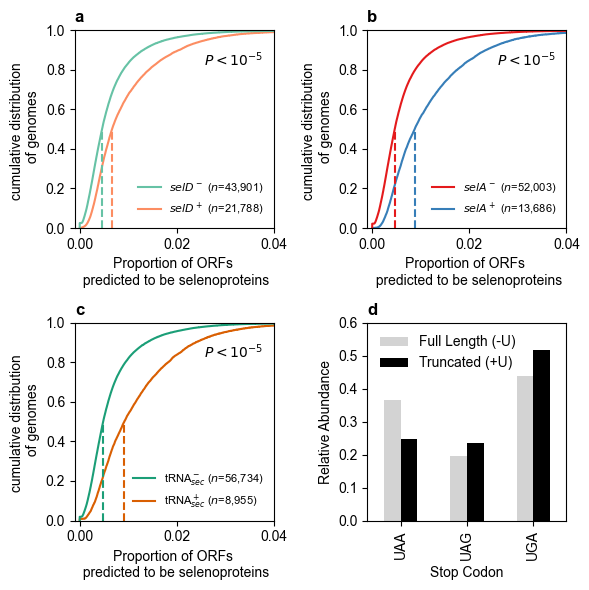

In [165]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu


# Function to perform Mann-Whitney U test and annotate plot
def annotate_mannwhitney(ax, data, group_var, value_var):
    group1 = data[data[group_var] == True][value_var].dropna().values.tolist()
    group2 = data[data[group_var] == False][value_var].dropna().values.tolist()
    
    # Perform the Mann-Whitney U test
    u_stat, p_value = mannwhitneyu(group1, group2)
    
    # Format p-value for annotation
    if p_value < 1e-15:
        p_text = "$P < 10^{-5}$"
    else:
        exponent = np.floor(np.log10(p_value))
        p_text = f"$P < 10^{{{int(exponent)}}}$"

    # Annotate the plot
    ax.text(0.65, 0.9, p_text, transform=ax.transAxes, fontsize=10, verticalalignment='top')

# Function to add median lines to ECDF plots
def add_median_lines(ax, data, hue, x_var, palette):
    if hue:
        # If 'hue' is used, calculate and plot medians for each hue category
        hue_categories = data[hue].unique()
        colors = sns.color_palette(palette, len(hue_categories))
        for i, category in enumerate(hue_categories):
            median = data[data[hue] == category][x_var].median()
            ax.axvline(median, 0, 0.5, color=colors[i], linestyle='--')
    else:
        # If no 'hue', just calculate and plot the median for the entire dataset
        median = data[x_var].median()
        ax.axvline(median, 0, 0.5, color='black', linestyle='--')
        
        
def update_legend(ax, positive_label, negative_label, legend_fontsize=8, handlelength=1.5):
    legend = ax.legend_
    if legend:
        new_labels = [positive_label if text.get_text() == 'True' else negative_label for text in legend.texts]
        
        # Create new handles with the desired line length
        new_handles = [plt.Line2D([], [], c=handle.get_c(), linewidth=handlelength) for handle in legend.legend_handles]

        # Set the new legend with updated handles and labels
        ax.legend(new_handles, new_labels, frameon=False, title='', fontsize=legend_fontsize)


XLIM = 0.04
# Create a figure with a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

# Subplot a

sns.ecdfplot(ax=axs[0, 0], x="selenoprotein_prop", hue="SelD_pos", data=results_df, palette="Set2")
add_median_lines(axs[0, 0], results_df, "SelD_pos", "selenoprotein_prop", "Set2")

pos_count = results_df[results_df["SelD_pos"] == True].shape[0]
neg_count = results_df[results_df["SelD_pos"] == False].shape[0]

axs[0, 0].set_xlim([-0.001, XLIM])
axs[0, 0].set_xlabel("Proportion of ORFs \n predicted to be selenoproteins")
axs[0, 0].set_ylabel("cumulative distribution \n of genomes")
axs[0, 0].set_title('a',loc='left', fontweight='bold')
pos_label,neg_label = f'$selD^+$ ($n$={format(pos_count,",")})', f'$selD^-$ ($n$={format(neg_count,",")})'
update_legend(axs[0, 0], pos_label,neg_label )
annotate_mannwhitney(axs[0, 0], results_df, "SelD_pos", "selenoprotein_prop")


# Subplot b
sns.ecdfplot(ax=axs[0, 1], x="selenoprotein_prop", hue="SelA_pos", data=results_df, palette="Set1")
add_median_lines(axs[0, 1], results_df, "SelA_pos", "selenoprotein_prop", "Set1")
pos_count = results_df[results_df["SelA_pos"] == True].shape[0]
neg_count = results_df[results_df["SelA_pos"] == False].shape[0]
axs[0, 1].set_xlim([-0.001, XLIM])
axs[0, 1].set_xlabel("Proportion of ORFs \n predicted to be selenoproteins")
axs[0, 1].set_ylabel("cumulative distribution \n of genomes")
axs[0, 1].set_title('b',loc='left', fontweight='bold')
pos_label,neg_label = f'$selA^+$ ($n$={format(pos_count,",")})', f'$selA^-$ ($n$={format(neg_count,",")})'
update_legend(axs[0, 1], pos_label,neg_label )
annotate_mannwhitney(axs[0, 1], results_df, "SelA_pos", "selenoprotein_prop")

# Subplot c
sns.ecdfplot(ax=axs[1, 0], x="selenoprotein_prop", hue="trna_sec_pos", data=results_df, palette="Dark2")
add_median_lines(axs[1, 0], results_df, "trna_sec_pos", "selenoprotein_prop", "Dark2")
pos_count = results_df[results_df["trna_sec_pos"] == True].shape[0]
neg_count = results_df[results_df["trna_sec_pos"] == False].shape[0]

axs[1, 0].set_xlim([-0.001, XLIM])
axs[1, 0].set_xlabel("Proportion of ORFs \n predicted to be selenoproteins")
axs[1, 0].set_ylabel("cumulative distribution \n of genomes")
axs[1, 0].set_title('c',loc='left', fontweight='bold')
pos_label = f'tRNA$_{{sec}}^+$ ($n$={format(pos_count,",")})'
neg_label = f'tRNA$_{{sec}}^-$ ($n$={format(neg_count,",")})'
update_legend(axs[1, 0], pos_label,neg_label )
annotate_mannwhitney(axs[1, 0], results_df, "trna_sec_pos", "selenoprotein_prop")

#update_legend(axs[1, 0], 'tRNA$_{sec}^+$', 'tRNA$_{sec}^-$')

# Subplot d (example bar plot, replace with your actual data)
# Example data for bar plot
# Normalize the counts within each ProteinClass
z = pd.DataFrame(results_df[["UGA_Selenoproteins","UAA_Selenoproteins","UAG_Selenoproteins","UAA_FullLength","UAG_FullLength","UGA_FullLength"]].sum(),columns=["counts"])
z["STOP_CODON"] = [x.split("_")[0] for x in z.index.tolist()]
z["ProteinClass"] = [x.split("_")[1] for x in z.index.tolist()]
z['normalized_counts'] = z.groupby('ProteinClass')['counts'].transform(lambda x: x / x.sum())

# Pivot the DataFrame for grouped bar plot
pivot_df = z.pivot(index='STOP_CODON', columns='ProteinClass', values='normalized_counts')

# Subplot d (example bar plot, replace with your actual data)
pivot_df.plot(kind='bar', ax=axs[1, 1], color=['lightgrey', 'black'])
axs[1, 1].set_ylim([0,0.6])
# Set labels and title
axs[1, 1].set_xlabel('Stop Codon')
axs[1, 1].set_ylabel('Relative Abundance')
axs[1, 1].set_title('d',loc='left', fontweight='bold')
axs[1, 1].legend([ "Full Length (-U)","Truncated (+U)"])
axs[1, 1].legend_.set_frame_on(False)


# Adjust layout and show the plot
plt.tight_layout()
plt.savefig("fig2.svg")

In [168]:
z.groupby("ProteinClass").sum()

,counts,STOP_CODON,normalized_counts
ProteinClass,,,
FullLength,187629739.0,UAAUAGUGA,1.0
Selenoproteins,1689764.0,UGAUAAUAG,1.0


In [172]:
z

,counts,STOP_CODON,ProteinClass,normalized_counts
UGA_Selenoproteins,874663.0,UGA,Selenoproteins,0.517624
UAA_Selenoproteins,415587.0,UAA,Selenoproteins,0.245944
UAG_Selenoproteins,399514.0,UAG,Selenoproteins,0.236432
UAA_FullLength,68509693.0,UAA,FullLength,0.365132
UAG_FullLength,36809780.0,UAG,FullLength,0.196183
UGA_FullLength,82310266.0,UGA,FullLength,0.438685


In [174]:
82310266.0 / 187629739.0

0.43868454136686724

In [173]:
874663.0 / 1689764.0

0.517624354643607

In [9]:
r_allp = pd.read_pickle("../results/depracated/selenoprotein_results.07Nov2023.pkl")
r_allp.index = ["_".join(x.split("_")[1:]) for x in r_allp.index.tolist()]
r_allp = r_allp[["total_hits"]]
r_allp.columns = ["all_hits"]

In [10]:
results_df = results_df.join(r_allp)

In [11]:
results_df["truncated_hits"] = results_df["all_hits"] - results_df["total_hits"] 

In [12]:
results_df["truncated_genes"] = results_df["ORF count"] - results_df["total_genes"] 

In [13]:
r = results_df[results_df.truncated_genes > 0]

In [14]:
r["truncated_hit_rate"] =  r.truncated_hits / r.truncated_genes
r["total_hit_rate"] = r.total_hits / r.total_genes

/var/folders/3j/34c1_59d1vx7bpvrgk4nbnt40000gn/T/ipykernel_21150/1989955485.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r["truncated_hit_rate"] =  r.truncated_hits / r.truncated_genes
/var/folders/3j/34c1_59d1vx7bpvrgk4nbnt40000gn/T/ipykernel_21150/1989955485.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r["total_hit_rate"] = r.total_hits / r.total_genes


In [46]:
#sns.scatterplot(x="total_hit_rate",y="truncated_hit_rate",data=r)

In [47]:
#sns.displot(x="total_hit_rate",data=r)
#sns.displot(x="truncated_hit_rate",data=r)

In [48]:
ko_selenocounts = pd.read_csv("../results/KO.selenocounts.fullLength.13Nov2023.csv",index_col=0)

In [49]:
ko_selenocounts["seleno_fraction"] = ko_selenocounts["seleno_counts"] / ko_selenocounts["counts"]

In [50]:
ko_selenocounts.sort_values("seleno_fraction",ascending=False).iloc[0:20]

,counts,seleno_counts,seleno_fraction
K21579,49.0,49.0,1.000000
K19594,178.0,177.0,0.994382
K22338,75.0,74.0,0.986667
K23549,2165.0,2098.0,0.969053
K10672,2250.0,2171.0,0.964889
K00440,428.0,407.0,0.950935
K00437,286.0,260.0,0.909091
K10794,1850.0,1680.0,0.908108
K18902,2254.0,1955.0,0.867347
K14126,2095.0,1798.0,0.858234


In [57]:
import cbtk.kegg as kegg_api 

In [58]:
ko2md = kegg_api.link("ko","md")
ko2md.columns = ["module","ko"]
ko2md["module"] = ko2md["module"].apply(lambda x: x.split(":")[1])
ko2md["ko"] = ko2md["ko"].apply(lambda x: x.split(":")[1])

In [59]:
res_module = {"module":[],"fc":[], "pval":[]}
for module,dff in ko2md.groupby("module"):
    k = dff.ko.tolist()
    k = [x for x in k if x in ko_selenocounts.index]
    x = ko_selenocounts.loc[k].seleno_fraction.values
    y = ko_selenocounts.loc[~ko_selenocounts.index.isin(k)].seleno_fraction.values
    
    if len(x)>1:
        _,pval = mannwhitneyu(x,y)
        fc = np.log2((np.mean(x) + 1e-5)/ (np.mean(y)+ 1e-5))
        res_module["module"].append(module)
        res_module["fc"].append(fc)
        res_module["pval"].append(pval)

res_module = pd.DataFrame(res_module)
_,adj_pvals,_,_= multipletests(res_module["pval"].values,method="fdr_bh")
res_module["adj_pval"] =  adj_pvals
res_module["log10(qval)"] = res_module["adj_pval"].apply(lambda x: -np.log10(x))

In [60]:
modules = kegg_api.list("md")
modules.columns = ["module","module_name"]

In [51]:
agg_res = results_df[["total_hits","hits_with_kegg_annotation","total_genes","total_genes_with_kegg_annotation"]].sum()
agg_res

total_hits                            1689764
hits_with_kegg_annotation              176882
total_genes                         189319503
total_genes_with_kegg_annotation     93869222
dtype: object

In [52]:
x1_bar = agg_res.hits_with_kegg_annotation / agg_res.total_hits
x2_bar = agg_res.total_genes_with_kegg_annotation / agg_res.total_genes
df_for_plot  = pd.DataFrame(pd.Series([x1_bar,x2_bar],index=["Predicted \n Selenoproteins","All Proteins"]),columns=["fraction with annotation"])
df_for_plot = df_for_plot.reset_index()
df_for_plot.columns = ["Proteins","fraction with annotation"]

In [86]:
#189319503 / 65000

/var/folders/3j/34c1_59d1vx7bpvrgk4nbnt40000gn/T/ipykernel_21150/3236558969.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Proteins",y="fraction with annotation",data=df_for_plot,palette="Greys_r")


Text(0.5, 0, '')

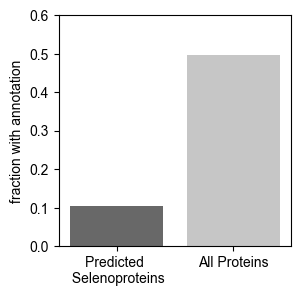

In [26]:
plt.figure(figsize=(3, 3))
sns.barplot(x="Proteins",y="fraction with annotation",data=df_for_plot,palette="Greys_r")
plt.ylim([0, 0.6])
plt.xlabel("")

In [61]:
res_module = res_module.set_index("module").join(modules.set_index("module"))

Methanogenesis, methanol => methane M00356
Methanogenesis, acetate => methane M00357
Methanogenesis, methylamine/dimethylamine/trimethylamine => methane M00563
Methanogenesis, CO2 => methane M00567


/var/folders/3j/34c1_59d1vx7bpvrgk4nbnt40000gn/T/ipykernel_21189/581761967.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axs[0],x="Proteins",y="fraction with annotation",data=df_for_plot,palette="Greys_r")


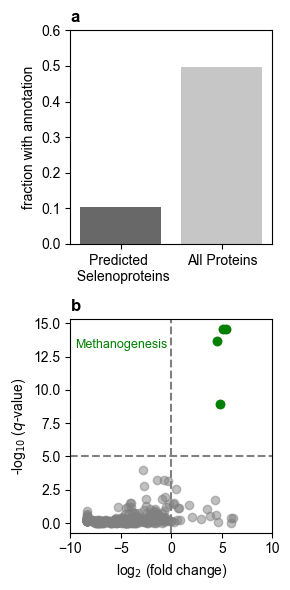

In [101]:

fig, axs = plt.subplots(2, 1, figsize=(3, 6))

#plt.figure(figsize=(3, 3))
sns.barplot(ax=axs[0],x="Proteins",y="fraction with annotation",data=df_for_plot,palette="Greys_r")
axs[0].set_ylim([0, 0.6])
axs[0].set_xlabel("")


# Create the volcano plot
#plt.figure(figsize=(3, 3))
axs[1].scatter(res_module['fc'], res_module['log10(qval)'], alpha=0.5,color='grey')

# Highlight and label points where -log(qval) > 5
highlight = res_module[res_module['log10(qval)'] > 5]
axs[1].scatter(highlight['fc'], highlight['log10(qval)'], color='green', alpha=1)
for _, row in highlight.iterrows():
    #plt.text(row['fc'], row['log10(qval)'], row.module_name, fontsize=8)
    print(row.module_name + " " + row.name)

# Labeling the top left with 'Methanogenesis'
axs[1].text(-9.5, max(res_module['log10(qval)']) * 0.9, 'Methanogenesis', color='green', fontsize=9)
axs[1].set_xlabel('log$_2$ (fold change)')
axs[1].set_ylabel('-log$_{10}$ ($q$-value)')
#plt.title('Volcano Plot')
axs[1].axhline(y=5, color='gray', linestyle='--')  # Threshold line for -log(qval) > 5
axs[1].axvline(x=0, color='gray', linestyle='--')  # Line at x=0
axs[1].set_xlim([-10,10])

axs[0].set_title('a',loc='left', fontweight='bold')
axs[1].set_title('b',loc='left', fontweight='bold')

plt.tight_layout()

#plt.show()

In [65]:
m = ["M00356","M00357","M00563","M00567"]
k = ko2md[ko2md.module.isin(m)].ko.tolist()
k = [x for x in k if x in ko_selenocounts.index]
#ko_selenocounts.loc[k
K = ko_selenocounts.copy()
K["methanogensis"] = ko_selenocounts.index.isin(k)

In [130]:
pd.DataFrame(k,columns=["KO"]).to_csv("KO_methanogensis.csv")

In [123]:
K[K.methanogensis].sort_values("seleno_fraction",ascending=False)

,counts,seleno_counts,seleno_fraction,methanogensis
K14126,2095.0,1798.0,0.858234,True
K00125,4967.0,3568.0,0.718341,True
K03390,7667.0,2051.0,0.267510,True
K03388,12088.0,2278.0,0.188451,True
K08265,137.0,15.0,0.109489,True
K22480,163.0,11.0,0.067485,True
K08264,19283.0,1058.0,0.054867,True
K22482,211.0,8.0,0.037915,True
K22481,225.0,7.0,0.031111,True
K14127,6850.0,176.0,0.025693,True


In [141]:
Km = K[K.methanogensis]

In [147]:
Km[Km.seleno_counts > 100]

,counts,seleno_counts,seleno_fraction,methanogensis
K00125,4967.0,3568.0,0.718341,True
K03388,12088.0,2278.0,0.188451,True
K03390,7667.0,2051.0,0.267510,True
K08264,19283.0,1058.0,0.054867,True
K14126,2095.0,1798.0,0.858234,True
K14127,6850.0,176.0,0.025693,True


In [67]:
mttB = "K14083"
mtbB = "K16178"
mtmB = "K16176"
K.loc[[mttB,mtbB,mtmB]]

,counts,seleno_counts,seleno_fraction,methanogensis
K14083,18286.0,98.0,0.005359,True
K16178,347.0,2.0,0.005764,True
K16176,1215.0,8.0,0.006584,True


In [103]:
#K[K.counts > 1000].sort_values("seleno_fraction")

In [122]:
K

,counts,seleno_counts,seleno_fraction,methanogensis
K00001,693.0,0.0,0.000000,False
K00002,59.0,0.0,0.000000,False
K00003,45661.0,0.0,0.000000,False
K00004,4175.0,2.0,0.000479,False
K00005,5663.0,1.0,0.000177,False
...,...,...,...,...
K25995,1147.0,0.0,0.000000,False
K25996,1220.0,0.0,0.000000,False
K26005,659.0,0.0,0.000000,False
K26006,1.0,0.0,0.000000,False


In [115]:
group_vars = ["domain","phyla"]
q = results_df[group_vars + ["hit_fraction"]].groupby(group_vars).mean().sort_values("hit_fraction",ascending=False).reset_index()

In [120]:
#results_df[results_df.phyla == "JABMQX01"]

In [121]:
results_df

,total_hits,hits_with_kegg_annotation,total_genes,total_genes_with_kegg_annotation,kegg_anotation_counts,selD_copy_num,selA_copy_num,total_genes_with_pfam_annotation,pfam_annotation_counts,ambiguous_bases,...,trna_sec_pos,UGA_Selenoproteins,UAA_Selenoproteins,UAG_Selenoproteins,UAA_FullLength,UAG_FullLength,UGA_FullLength,hit_fraction,ORF count,selenoprotein_prop
GCA_014654065.1,1,0,1252,746,{},0,0,0,{},0,...,False,1.0,0.0,0.0,910,158,183.0,0.000799,1306,0.000766
GCA_002479145.1,8,0,1407,709,{},0,0,1,{'PF00881': 1},55,...,False,1.0,4.0,3.0,682,322,395.0,0.005686,1496,0.005348
GCA_014377155.1,32,0,3848,2383,{},2,1,3,"{'PF01554': 1, 'PF13737': 1, 'PF17785': 1}",0,...,True,13.0,12.0,7.0,1158,682,1976.0,0.008316,4682,0.006835
GCA_903829855.1,21,1,1655,858,{'K07788': 1},0,0,NaN,{},0,...,False,10.0,9.0,2.0,808,156,670.0,0.012689,2170,0.009677
GCA_002923395.1,3,0,565,279,{},0,0,1,{'PF00664': 1},0,...,False,0.0,3.0,0.0,438,64,60.0,0.005310,600,0.005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCA_910579245.1,6,2,1466,779,"{'K03615': 1, 'K07451': 1}",0,0,2,"{'PF01512': 1, 'PF09084': 1, 'PF10531': 1, 'PF...",0,...,False,1.0,3.0,2.0,794,237,429.0,0.004093,1746,0.003436
GCF_001446935.1,9,1,4133,2661,{'K18299': 1},1,0,1,{'PF00873': 1},0,...,False,6.0,2.0,1.0,1643,421,2060.0,0.002178,4152,0.002168
GCF_001953955.1,9,2,2285,934,"{'K07452': 1, 'K07488': 1}",0,0,NaN,{},0,...,False,2.0,3.0,4.0,1615,370,291.0,0.003939,2288,0.003934
GCF_000716435.1,73,0,10130,4078,{},0,0,NaN,{},0,...,False,51.0,4.0,18.0,668,1929,7460.0,0.007206,10375,0.007036
